In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

ImportError: dlopen(/Users/kamyar/anaconda3/lib/python3.10/site-packages/scipy/sparse/linalg/_isolve/_iterative.cpython-310-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib
  Referenced from: <FFE3DC09-48E5-37F8-9231-E5E0A38C335B> /Users/kamyar/anaconda3/lib/python3.10/site-packages/scipy/sparse/linalg/_isolve/_iterative.cpython-310-darwin.so
  Reason: tried: '/Users/kamyar/anaconda3/lib/python3.10/site-packages/scipy/sparse/linalg/_isolve/liblapack.3.dylib' (no such file), '/Users/kamyar/anaconda3/lib/python3.10/site-packages/scipy/sparse/linalg/_isolve/../../../../../../liblapack.3.dylib' (no such file), '/Users/kamyar/anaconda3/lib/python3.10/site-packages/scipy/sparse/linalg/_isolve/liblapack.3.dylib' (no such file), '/Users/kamyar/anaconda3/lib/python3.10/site-packages/scipy/sparse/linalg/_isolve/../../../../../../liblapack.3.dylib' (no such file), '/Users/kamyar/anaconda3/bin/../lib/liblapack.3.dylib' (no such file), '/Users/kamyar/anaconda3/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file, not in dyld cache)

In [60]:
data = pd.read_excel('data_DP.xlsx')
data.drop(axis=1, inplace=True, columns=['-logC','MaxWaveLength'])
data.shape

(199, 685)

In [61]:
X = data.iloc[:,1:-3]
X.columns = X.columns.astype(str)
y = data.iloc[:,0]
X.shape

(199, 681)

In [62]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
st = StandardScaler()
X = st.fit_transform(X)
y = st.fit_transform(np.array(y).reshape(-1,1))
y.shape

(199, 1)

In [63]:
from sklearn.ensemble import IsolationForest
print(X.shape,y.shape)
iso = IsolationForest(contamination=0.05)
yhat = iso.fit_predict(X)
mask = yhat != -1
X, y = X[mask, :], y[mask]
print(X.shape, y.shape)

(199, 681) (199, 1)
(189, 681) (189, 1)


In [65]:
y = np.array(y).reshape(-1,)
y.shape

(189,)

In [68]:
from sklearn.manifold import SpectralEmbedding

#apply Isomap on the data
iso = SpectralEmbedding(n_components=5,affinity='rbf',n_neighbors=10)
X_iso = iso.fit_transform(X)
#create the new dataset
df_iso  = pd.concat([pd.DataFrame(X_iso),pd.DataFrame(y,columns=["final"])], axis=1)
df_iso

0         1         2         3         4     final
0    0.012146 -0.022434  0.016946  0.001788  0.035102 -1.214278
1    0.009251 -0.017895  0.012349  0.001295  0.016934 -1.157714
2    0.009649 -0.011133  0.012738  0.000514  0.011659 -1.101150
3    0.009946 -0.007927  0.011820  0.000275  0.009657 -1.044586
4    0.009369 -0.001915  0.009346 -0.000384  0.003567 -0.988022
..        ...       ...       ...       ...       ...       ...
184 -0.010728  0.000784 -0.004891  0.006975  0.006221  1.104845
185 -0.009713  0.003420 -0.002089 -0.002298  0.007304  1.331101
186 -0.006250  0.004491 -0.003809 -0.010590  0.004599  1.557357
187 -0.003999  0.005578 -0.003800 -0.014471  0.002966  1.783613
188 -0.003598  0.006675  0.001459 -0.015425  0.001060  2.009869

[189 rows x 6 columns]

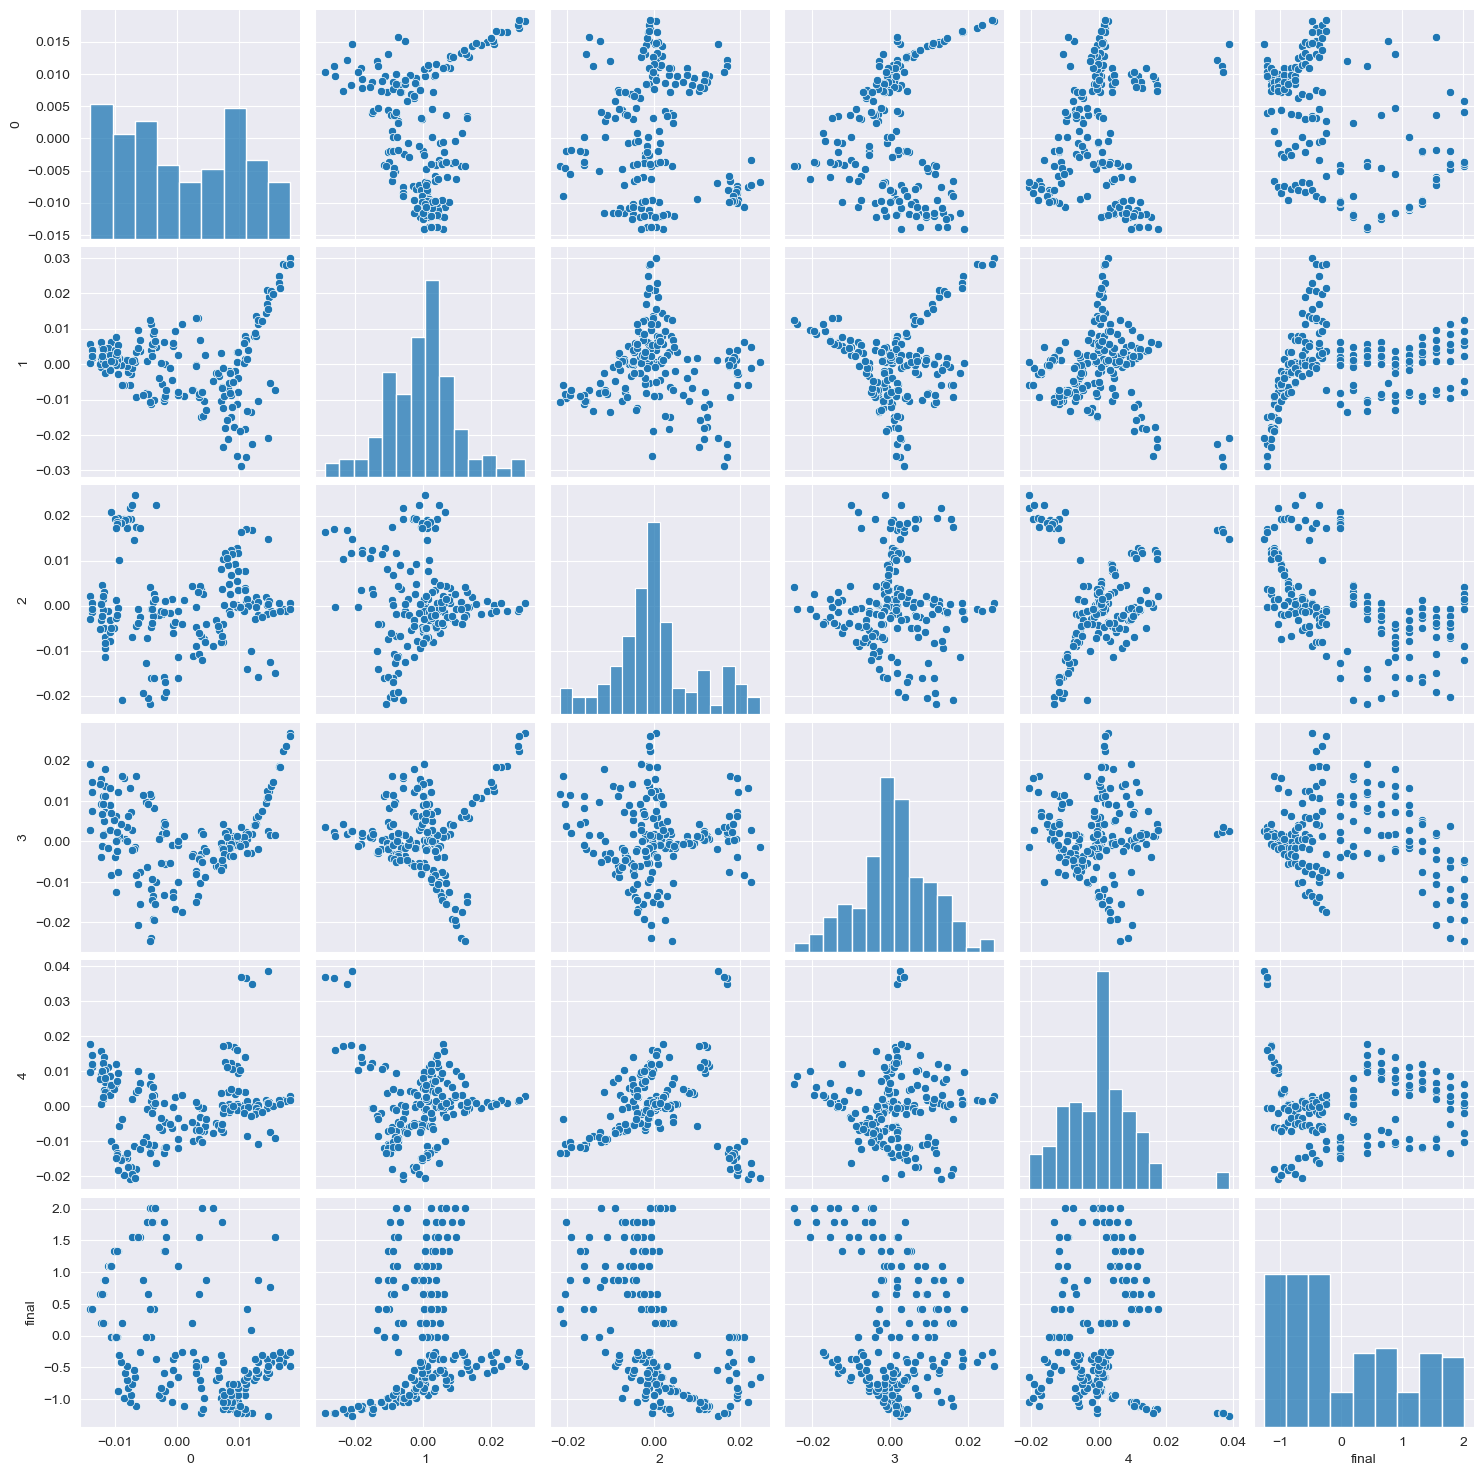

In [69]:
sns.pairplot(df_iso)


In [47]:
#import LLE
from sklearn.manifold import LocallyLinearEmbedding

#create an instance of the class
lle = LocallyLinearEmbedding(n_components=5)
X_lle = lle.fit_transform(X)

#create the new dataset
df_lle = pd.concat([pd.DataFrame(X_lle), pd.DataFrame(y,columns=["final"])], axis=1)
df_lle

0         1         2         3         4     final
0    0.070001 -0.033231 -0.072558 -0.023823  0.313721 -1.214278
1    0.070001 -0.054359 -0.021357 -0.045880 -0.141616 -1.157714
2    0.070001 -0.067577 -0.003348 -0.024329 -0.125698 -1.101150
3    0.070001 -0.074125  0.005765 -0.013394 -0.119694 -1.044586
4    0.070001 -0.086461  0.016911 -0.000543 -0.064055 -0.988022
..        ...       ...       ...       ...       ...       ...
184  0.070001  0.084409  0.025266 -0.083860  0.021521  1.104845
185  0.070001  0.084227  0.022936 -0.022560  0.012739  1.331101
186  0.070001  0.083869  0.019545  0.050119  0.003472  1.557357
187  0.070001  0.083659  0.017452  0.096198 -0.002521  1.783613
188  0.070001  0.084045  0.021325  0.007019  0.009112  2.009869

[189 rows x 6 columns]

In [66]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoLarsCV
from sklearn.model_selection import RepeatedKFold, cross_validate
num_features = [i for i in range(5, X.shape[1],5)]
mean_r2_mut_train = []
mean_rmse_mut_train = []
mean_r2_f_train = []
mean_rmse_f_train = []
mean_r2_mut_test = []
mean_rmse_mut_test = []
mean_r2_f_test = []
mean_rmse_f_test = []
cv_lasso = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=3)
for i in num_features:
    model = LassoLarsCV(cv=cv_lasso,n_jobs=-1)
    st = StandardScaler()
    # fs_mut = SelectKBest(score_func=mutual_info_regression, k=i)
    iso = Isomap(n_components=i)
    pipeline = Pipeline(steps=[('Iso',iso),('StandardScaler',st),('Linear_model', model)])
    scores_mut = cross_validate(pipeline, X, y, scoring=['r2','neg_root_mean_squared_error'], cv=cv, n_jobs=-1, return_train_score=True)
    mean_r2_mut_train.append(np.mean(scores_mut['train_r2']))
    mean_rmse_mut_train.append((-1) * np.mean(scores_mut['train_neg_root_mean_squared_error']))
    mean_r2_mut_test.append(np.mean(scores_mut['test_r2']))
    mean_rmse_mut_test.append((-1) * np.mean(scores_mut['test_neg_root_mean_squared_error']))
    print('Train: >%d %.3f (%.3f)' % (i, np.mean(scores_mut['train_r2']), np.std(scores_mut['train_r2'])))
    print('Test:  >%d %.3f (%.3f)' % (i, np.mean(scores_mut['test_r2']), np.std(scores_mut['test_r2'])))

for i in num_features:
    model = LassoLarsCV(cv=cv_lasso,n_jobs=-1)
    st = StandardScaler()
    # fs_f = SelectKBest(score_func=f_regression, k=i)
    lle = LocallyLinearEmbedding(n_components=i)
    pipeline = Pipeline(steps=[('LLE',lle), ('StandardScaler',st),('Linear_model', model)])
    scores_f = cross_validate(pipeline, X, y, scoring=['r2','neg_root_mean_squared_error'], cv=cv, n_jobs=-1, return_train_score=True)
    mean_r2_f_train.append(np.mean(scores_f['train_r2']))
    mean_rmse_f_train.append((-1) * np.mean(scores_f['train_neg_root_mean_squared_error']))
    mean_r2_f_test.append(np.mean(scores_f['test_r2']))
    mean_rmse_f_test.append((-1) * np.mean(scores_f['test_neg_root_mean_squared_error']))
    print('Train: >%d %.3f (%.3f)' % (i, np.mean(scores_f['train_r2']), np.std(scores_f['train_r2'])))
    print('Test:  >%d %.3f (%.3f)' % (i, np.mean(scores_f['test_r2']), np.std(scores_f['test_r2'])))




/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity s

Train: >5 0.463 (0.101)
Test:  >5 0.370 (0.122)
Train: >10 0.560 (0.068)
Test:  >10 0.434 (0.163)


/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity s

Train: >15 0.601 (0.104)
Test:  >15 0.264 (0.620)
Train: >20 0.614 (0.115)
Test:  >20 0.282 (0.613)


/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity s

Train: >25 0.604 (0.129)
Test:  >25 0.274 (0.576)


/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity s

Train: >30 0.598 (0.134)
Test:  >30 0.293 (0.519)


/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity s

Train: >35 0.589 (0.139)
Test:  >35 0.275 (0.539)


/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity s

Train: >40 0.590 (0.145)
Test:  >40 0.256 (0.597)


/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity s

Train: >45 0.582 (0.148)
Test:  >45 0.277 (0.535)


/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity s

Train: >50 0.580 (0.148)
Test:  >50 0.301 (0.450)


/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity s

Train: >55 0.577 (0.146)
Test:  >55 0.310 (0.433)


/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity s

Train: >60 0.573 (0.144)
Test:  >60 0.282 (0.548)


/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity s

Train: >65 0.572 (0.143)
Test:  >65 0.293 (0.515)


/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity s

Train: >70 0.570 (0.142)
Test:  >70 0.265 (0.517)


/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity s

Train: >75 0.569 (0.142)
Test:  >75 0.273 (0.496)


/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity s

Train: >80 0.569 (0.142)
Test:  >80 0.275 (0.490)


/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity s

Train: >85 nan (nan)
Test:  >85 nan (nan)


/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
2 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/s

ValueError: 
All the 15 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 373, in fit_transform
    self._fit_transform(X)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 305, in _fit_transform
    self.embedding_ = self.kernel_pca_.fit_transform(G)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 456, in fit_transform
    self.fit(X, **params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 424, in fit
    self._fit_transform(K)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 348, in _fit_transform
    self.eigenvalues_ = _check_psd_eigenvalues(
                        ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1681, in _check_psd_eigenvalues
    raise ValueError(
ValueError: There are significant negative eigenvalues (1.70071e-05 of the maximum positive). Either the matrix is not PSD, or there was an issue while computing the eigendecomposition of the matrix.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 373, in fit_transform
    self._fit_transform(X)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 305, in _fit_transform
    self.embedding_ = self.kernel_pca_.fit_transform(G)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 456, in fit_transform
    self.fit(X, **params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 424, in fit
    self._fit_transform(K)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 348, in _fit_transform
    self.eigenvalues_ = _check_psd_eigenvalues(
                        ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1681, in _check_psd_eigenvalues
    raise ValueError(
ValueError: There are significant negative eigenvalues (2.15625e-05 of the maximum positive). Either the matrix is not PSD, or there was an issue while computing the eigendecomposition of the matrix.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 373, in fit_transform
    self._fit_transform(X)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 305, in _fit_transform
    self.embedding_ = self.kernel_pca_.fit_transform(G)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 456, in fit_transform
    self.fit(X, **params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 424, in fit
    self._fit_transform(K)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 348, in _fit_transform
    self.eigenvalues_ = _check_psd_eigenvalues(
                        ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1681, in _check_psd_eigenvalues
    raise ValueError(
ValueError: There are significant negative eigenvalues (2.63231e-05 of the maximum positive). Either the matrix is not PSD, or there was an issue while computing the eigendecomposition of the matrix.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 373, in fit_transform
    self._fit_transform(X)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 305, in _fit_transform
    self.embedding_ = self.kernel_pca_.fit_transform(G)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 456, in fit_transform
    self.fit(X, **params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 424, in fit
    self._fit_transform(K)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 348, in _fit_transform
    self.eigenvalues_ = _check_psd_eigenvalues(
                        ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1681, in _check_psd_eigenvalues
    raise ValueError(
ValueError: There are significant negative eigenvalues (3.04134e-05 of the maximum positive). Either the matrix is not PSD, or there was an issue while computing the eigendecomposition of the matrix.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 373, in fit_transform
    self._fit_transform(X)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 305, in _fit_transform
    self.embedding_ = self.kernel_pca_.fit_transform(G)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 456, in fit_transform
    self.fit(X, **params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 424, in fit
    self._fit_transform(K)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 348, in _fit_transform
    self.eigenvalues_ = _check_psd_eigenvalues(
                        ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1681, in _check_psd_eigenvalues
    raise ValueError(
ValueError: There are significant negative eigenvalues (2.23691e-05 of the maximum positive). Either the matrix is not PSD, or there was an issue while computing the eigendecomposition of the matrix.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 373, in fit_transform
    self._fit_transform(X)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 305, in _fit_transform
    self.embedding_ = self.kernel_pca_.fit_transform(G)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 456, in fit_transform
    self.fit(X, **params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 424, in fit
    self._fit_transform(K)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 348, in _fit_transform
    self.eigenvalues_ = _check_psd_eigenvalues(
                        ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1681, in _check_psd_eigenvalues
    raise ValueError(
ValueError: There are significant negative eigenvalues (2.71868e-05 of the maximum positive). Either the matrix is not PSD, or there was an issue while computing the eigendecomposition of the matrix.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 373, in fit_transform
    self._fit_transform(X)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 305, in _fit_transform
    self.embedding_ = self.kernel_pca_.fit_transform(G)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 456, in fit_transform
    self.fit(X, **params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 424, in fit
    self._fit_transform(K)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 348, in _fit_transform
    self.eigenvalues_ = _check_psd_eigenvalues(
                        ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1681, in _check_psd_eigenvalues
    raise ValueError(
ValueError: There are significant negative eigenvalues (2.68397e-05 of the maximum positive). Either the matrix is not PSD, or there was an issue while computing the eigendecomposition of the matrix.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 373, in fit_transform
    self._fit_transform(X)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 305, in _fit_transform
    self.embedding_ = self.kernel_pca_.fit_transform(G)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 456, in fit_transform
    self.fit(X, **params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 424, in fit
    self._fit_transform(K)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 348, in _fit_transform
    self.eigenvalues_ = _check_psd_eigenvalues(
                        ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1681, in _check_psd_eigenvalues
    raise ValueError(
ValueError: There are significant negative eigenvalues (2.91213e-05 of the maximum positive). Either the matrix is not PSD, or there was an issue while computing the eigendecomposition of the matrix.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 373, in fit_transform
    self._fit_transform(X)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 305, in _fit_transform
    self.embedding_ = self.kernel_pca_.fit_transform(G)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 456, in fit_transform
    self.fit(X, **params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 424, in fit
    self._fit_transform(K)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 348, in _fit_transform
    self.eigenvalues_ = _check_psd_eigenvalues(
                        ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1681, in _check_psd_eigenvalues
    raise ValueError(
ValueError: There are significant negative eigenvalues (2.22004e-05 of the maximum positive). Either the matrix is not PSD, or there was an issue while computing the eigendecomposition of the matrix.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 373, in fit_transform
    self._fit_transform(X)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 305, in _fit_transform
    self.embedding_ = self.kernel_pca_.fit_transform(G)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 456, in fit_transform
    self.fit(X, **params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 424, in fit
    self._fit_transform(K)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 348, in _fit_transform
    self.eigenvalues_ = _check_psd_eigenvalues(
                        ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1681, in _check_psd_eigenvalues
    raise ValueError(
ValueError: There are significant negative eigenvalues (2.18444e-05 of the maximum positive). Either the matrix is not PSD, or there was an issue while computing the eigendecomposition of the matrix.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 373, in fit_transform
    self._fit_transform(X)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 305, in _fit_transform
    self.embedding_ = self.kernel_pca_.fit_transform(G)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 456, in fit_transform
    self.fit(X, **params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 424, in fit
    self._fit_transform(K)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 348, in _fit_transform
    self.eigenvalues_ = _check_psd_eigenvalues(
                        ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1681, in _check_psd_eigenvalues
    raise ValueError(
ValueError: There are significant negative eigenvalues (1.46947e-05 of the maximum positive). Either the matrix is not PSD, or there was an issue while computing the eigendecomposition of the matrix.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 373, in fit_transform
    self._fit_transform(X)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 305, in _fit_transform
    self.embedding_ = self.kernel_pca_.fit_transform(G)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 456, in fit_transform
    self.fit(X, **params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 424, in fit
    self._fit_transform(K)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 348, in _fit_transform
    self.eigenvalues_ = _check_psd_eigenvalues(
                        ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1681, in _check_psd_eigenvalues
    raise ValueError(
ValueError: There are significant negative eigenvalues (2.06655e-05 of the maximum positive). Either the matrix is not PSD, or there was an issue while computing the eigendecomposition of the matrix.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 373, in fit_transform
    self._fit_transform(X)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 305, in _fit_transform
    self.embedding_ = self.kernel_pca_.fit_transform(G)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 456, in fit_transform
    self.fit(X, **params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 424, in fit
    self._fit_transform(K)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 348, in _fit_transform
    self.eigenvalues_ = _check_psd_eigenvalues(
                        ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1681, in _check_psd_eigenvalues
    raise ValueError(
ValueError: There are significant negative eigenvalues (3.24024e-05 of the maximum positive). Either the matrix is not PSD, or there was an issue while computing the eigendecomposition of the matrix.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 373, in fit_transform
    self._fit_transform(X)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 305, in _fit_transform
    self.embedding_ = self.kernel_pca_.fit_transform(G)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 456, in fit_transform
    self.fit(X, **params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 424, in fit
    self._fit_transform(K)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 348, in _fit_transform
    self.eigenvalues_ = _check_psd_eigenvalues(
                        ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1681, in _check_psd_eigenvalues
    raise ValueError(
ValueError: There are significant negative eigenvalues (3.33649e-05 of the maximum positive). Either the matrix is not PSD, or there was an issue while computing the eigendecomposition of the matrix.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 373, in fit_transform
    self._fit_transform(X)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py", line 305, in _fit_transform
    self.embedding_ = self.kernel_pca_.fit_transform(G)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 456, in fit_transform
    self.fit(X, **params)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 424, in fit
    self._fit_transform(K)
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py", line 348, in _fit_transform
    self.eigenvalues_ = _check_psd_eigenvalues(
                        ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/Ananconda/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1681, in _check_psd_eigenvalues
    raise ValueError(
ValueError: There are significant negative eigenvalues (1.65545e-05 of the maximum positive). Either the matrix is not PSD, or there was an issue while computing the eigendecomposition of the matrix.
